In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
import numpy as np

## Dataset

Esse dataset  simula transações de uma plataforma de carteira digital semelhante a serviços populares, ele contém 5000 registros de várias transações financeiras em várias categorias.

Ao total, possui 16 colunas que são de informações como:

- **idx**: índice exclusivo para cada registro
- **transaction_id**: identificador exclusivo para cada transação (UUID)
- **user_id**: identificador exclusivo para cada usuário
- **transaction_date**: data e hora da transação
- **product_category**: categoria do produto ou serviço
- **product_name**: nome específico do produto ou serviço
- **merchant_name**: nome do comerciante ou provedor de serviços
- **product_amount**: valor da transação em moeda local
- **transaction_fee**: taxa cobrada pela transação
- **cashback**: valor do cashback recebido pela transação
- **loyalty_points**: pontos de fidelidade ganhos com a transação
- **payment_method**: método usado para pagamento
- **transaction_status**: status da transação (bem-sucedida, com falha, pendente)
- **merchant_id**: identificador exclusivo para cada comerciante
- **device_type**: tipo de dispositivo usado para a transação
- **location**: categoria de localização ampla da transação


O objetivo é utlizar esses dados para obter o valor total das transações diárias e prever esse valor total para os próximos dias com base nos dias anteriores.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# carregando os dados


data = pd.read_csv('/content/drive/MyDrive/digital_wallet_transactions.csv')
data.head()

,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
0,1,4dac3ea3-6492-46ec-80b8-dc45c3ad0b14,USER_05159,2023-08-19 03:32,Rent Payment,2BHK Flat Deposit,Airbnb,1525.39,36.69,19.19,186,Debit Card,Successful,MERCH_0083,iOS,Urban
1,2,a903ed9f-eb84-47e7-b8aa-fd1786c919cf,USER_07204,2023-08-19 04:37,Gas Bill,Commercial Gas Connection,Adani Gas,1495.40,28.19,89.99,182,UPI,Successful,MERCH_0163,iOS,Urban
2,3,2a393013-733c-4add-9f09-bed1eeb33676,USER_00903,2023-08-19 05:52,Bus Ticket,Semi-Sleeper,MakeMyTrip Bus,1267.71,11.36,95.70,994,UPI,Successful,MERCH_0320,iOS,Urban
3,4,9a07ad19-4673-4794-9cd2-9b139f39c715,USER_01769,2023-08-19 06:35,Internet Bill,4G Unlimited Plan,Airtel Broadband,9202.63,6.41,82.24,409,Debit Card,Successful,MERCH_0194,Android,Urban
4,5,76418260-c985-4011-979d-0914604d0d68,USER_03544,2023-08-19 06:36,Loan Repayment,Home Loan EMI,Axis Bank,3100.58,41.15,40.47,837,Debit Card,Successful,MERCH_0504,Android,Urban


In [ ]:
# tratando os dados para que só fique a data e se somem os montantes por dia

data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data = data.groupby(data['transaction_date'].dt.date)['product_amount'].sum().reset_index()
data.columns = ['date', 'amount']
data.head()


,date,amount
0,2023-08-19,92322.84
1,2023-08-20,98997.36
2,2023-08-21,78421.39
3,2023-08-22,47604.89
4,2023-08-23,75365.93


In [ ]:
# normalização dos dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['amount'].values.reshape(-1, 1))

In [ ]:
# criando sequências

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 7
X, y = create_dataset(scaled_data, look_back)

## Treinamento modelo

In [ ]:
# Dividindo dados em treinamento e teste
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/100
8/8 - 1s - loss: 0.1488 - 1s/epoch - 186ms/step
Epoch 2/100
8/8 - 0s - loss: 0.0679 - 44ms/epoch - 5ms/step
Epoch 3/100
8/8 - 0s - loss: 0.0442 - 42ms/epoch - 5ms/step
Epoch 4/100
8/8 - 0s - loss: 0.0394 - 47ms/epoch - 6ms/step
Epoch 5/100
8/8 - 0s - loss: 0.0370 - 50ms/epoch - 6ms/step
Epoch 6/100
8/8 - 0s - loss: 0.0353 - 45ms/epoch - 6ms/step
Epoch 7/100
8/8 - 0s - loss: 0.0332 - 46ms/epoch - 6ms/step
Epoch 8/100
8/8 - 0s - loss: 0.0349 - 40ms/epoch - 5ms/step
Epoch 9/100
8/8 - 0s - loss: 0.0337 - 45ms/epoch - 6ms/step
Epoch 10/100
8/8 - 0s - loss: 0.0302 - 40ms/epoch - 5ms/step
Epoch 11/100
8/8 - 0s - loss: 0.0328 - 43ms/epoch - 5ms/step
Epoch 12/100
8/8 - 0s - loss: 0.0328 - 41ms/epoch - 5ms/step
Epoch 13/100
8/8 - 0s - loss: 0.0312 - 52ms/epoch - 7ms/step
Epoch 14/100
8/8 - 0s - loss: 0.0313 - 53ms/epoch - 7ms/step
Epoch 15/100
8/8 - 0s - loss: 0.0317 - 53ms/epoch - 7ms/step
Epoch 16/100
8/8 - 0s - loss: 0.0328 - 49ms/epoch - 6ms/step
Epoch 17/100
8/8 - 0s - loss: 0.0

In [ ]:
# Inverter as previsões
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

## Métrica MSE

In [ ]:
from sklearn.metrics import mean_squared_error
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} MSE')
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} MSE')

Train Score: 20223.44 MSE
Test Score: 23009.42 MSE


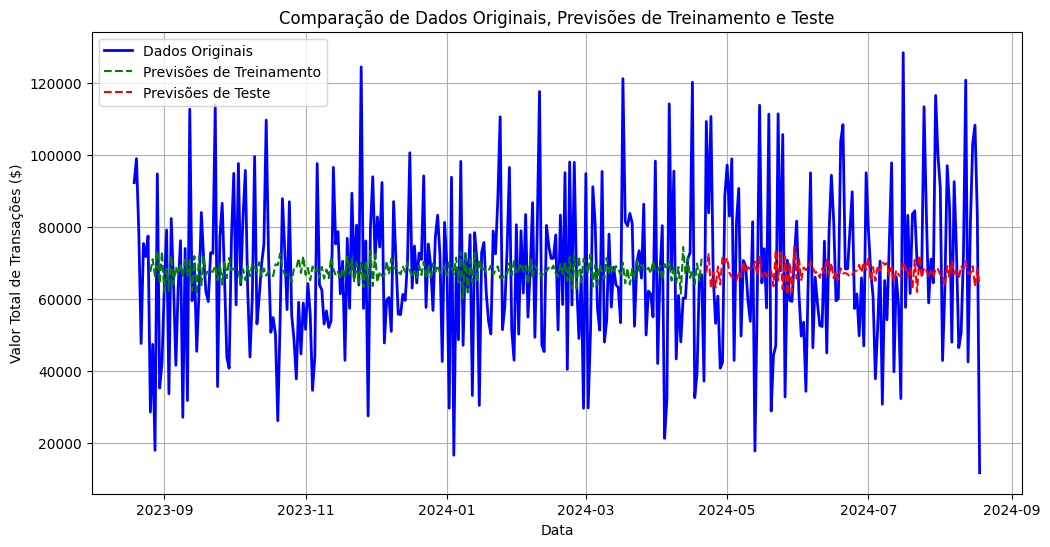

In [ ]:
# Ajustar as datas para correspondência com previsões de treinamento e teste
train_dates = data['date'][look_back:len(train_predict) + look_back]  # Ajuste para previsões de treinamento
test_dates = data['date'][-len(test_predict):]  # Ajuste para pegar as últimas datas correspondentes às previsões de teste

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(data['date'], scaler.inverse_transform(scaled_data), label='Dados Originais', color='blue', linewidth=2)
plt.plot(train_dates, train_predict, label='Previsões de Treinamento', color='green', linestyle='--')
plt.plot(test_dates, test_predict, label='Previsões de Teste', color='red', linestyle='--')
plt.legend()
plt.title('Comparação de Dados Originais, Previsões de Treinamento e Teste')
plt.xlabel('Data')
plt.ylabel('Valor Total de Transações ($)')
plt.grid(True)

plt.show()